# Где дешевле жить? Предсказание цен в Airbnb - учимся генерировать признаки и интерпретировать результаты модели. 

**Цель:** В этом проекте вы потренируетесь строить интерпретируемые модели линейной регрессии с регуляризацией и без, а также придумывать новые признаки для улучшения качества модели.

## Часть 1. EDA

1. Скачайте данные с Kaggle по ценам на жильё в Airbnb в Нью-Йорке: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data
2. Пройдите по основным шагам работы с данными - базовые статистики, визуализации (распределения, корреляции, pair plots), предобработка переменных. Переменные, которые пока нужно убрать: id, name, host_id, host_name, last_review.

## Часть 2. Preprocessing & Feature Engineering

Ваша цель получить как можно более высокие метрики качества (можно взять несколько, R2, MAE, RMSE), сконцентрировавшись на преобразовании признаков.

Опробуйте различные техники:
- работа с категориальными переменными (можно начать с dummy)
- замена аномалий
- различные варианты шкалирования непрерывных переменных (StandardScaler, RobustScaler, и.т.д.)
- обратите внимание на распределение целевой переменной, возможно, с ней тоже можно поработать

Попробуйте на основании имеющихся переменных создать новые, которые могли бы улучшить качество модели. Например, можно найти координаты Манхэттена (самого дорогого района) и при помощи широты и долготы, а также евклидового расстояния создать новую переменную - расстояние от квартиры до этого района. Возможно, такой признак будет работать лучше, чем просто широта и долгота.

## Часть 3. Моделирование

1. Отложите 30% данных для тестирования
2. Постройте модели простой линейной регрессии, RidgeCV, LassoCV и ElasticNetCV
3. Измерьте качество каждой и визуализируйте важность признаков
3. Сделайте интересные выводы :)

В ноутбуке желательно видеть:
1) Понятное описание: какие техники и алгоритмы были опробованы - было бы неплохо в самом начале тезисно выписать опробованные методики и их результат (помогло / не помогло).
2) Наличие визуализаций (не обязательно строить много графиков - можно несколько репрезентативных)
3) Наличие хотя бы одной модификации данных, приводящей к улучшению результатов

## Критерии оценки
- EDA - 2 балла
- Базовая предобработка и построенные модели с оценкой качества - 4 балла
- Дополнительная генерация признаков и проверка качества моделей с ними - 4 балла

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import Normalizer


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn import metrics

%matplotlib inline

In [2]:
data = pd.read_csv('AB_NYC_2019.csv')
data


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2


## Подготовка функционала для обучение и сбора метрик


In [3]:
 regression_list=[
    [LinearRegression(),'LinearRegression'],
    [RidgeCV(cv=5),'RidgeCV'],
    [LassoCV(cv=5),'LassoCV'],
    [ElasticNetCV(cv=5),'ElasticNetCV']]

scaler_list=[
    [StandardScaler(),'StandardScaler'],
    [RobustScaler(),'RobustScaler'],
    [MinMaxScaler(),'MinMaxScaler'],
    [MaxAbsScaler(),'MaxAbsScaler'],
    [ Normalizer(), 'Normalizer']
]

regression_list

[[LinearRegression(), 'LinearRegression'],
 [RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5), 'RidgeCV'],
 [LassoCV(cv=5), 'LassoCV'],
 [ElasticNetCV(cv=5), 'ElasticNetCV']]

In [4]:
#суммарный датафрейм со всеми результатами
result_columns = ['name','MAE','RMSE','R2']
result = pd.DataFrame([], columns=result_columns)

# Пример добавление данных в итоговую таблицу
#result = pd.concat([result, pd.DataFrame([['Linear',1,1,1)]], columns=result_columns)])

In [5]:
#функция тренировки модели
#возвращает обученую модель и посчитаные ошибки
def regression_fit(X_train, X_test, y_train, y_test, regressor, regressor_name):
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    return metrics.mean_absolute_error(y_test, y_pred), np.sqrt(metrics.mean_squared_error(y_test, y_pred)),metrics.r2_score(y_test, y_pred),regressor



In [6]:
#построение графика FE
def feature_importance_plot(train_columns,regressor,regressor_name):
    featureImportance = pd.DataFrame({"feature": train_columns.columns[regressor.coef_!=0], 
                                      "importance": regressor.coef_[regressor.coef_!=0]})

    featureImportance.set_index('feature', inplace=True)
    featureImportance.sort_values(["importance"], ascending=False, inplace=True)

    featureImportance["importance"].plot(kind='bar', figsize=(10, 5));    
    plt.title("Feature Importance - " + regressor_name)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.show()

In [7]:
def report(report_data):
    print("Min MAE")
    for index, row in report_data[report_data['MAE']==report_data['MAE'].min()].iterrows():
        print(row['name'], row['MAE'])
    print("---------")
    print("Min RMSE")
    for index, row in report_data[report_data['RMSE']==report_data['RMSE'].min()].iterrows():
        print(row['name'], row['RMSE'])
    print("---------")
    print("MAX R2")
    for index, row in report_data[report_data['R2']==report_data['R2'].max()].iterrows():
        print(row['name'], row['R2'])

# EDA


1. Подотовим список столбцов которые никак не влияют на результат
2. Проверим базовые характеристики
3. Проверим пропуски

In [8]:
DROP_COLUMNS = ['id', 'name', 'host_id', 'host_name', 'last_review']
data=data.drop(DROP_COLUMNS, axis=1)

In [9]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   neighbourhood                   48895 non-null  object 
 2   latitude                        48895 non-null  float64
 3   longitude                       48895 non-null  float64
 4   room_type                       48895 non-null  object 
 5   price                           48895 non-null  int64  
 6   minimum_nights                  48895 non-null  int64  
 7   number_of_reviews               48895 non-null  int64  
 8   reviews_per_month               38843 non-null  float64
 9   calculated_host_listings_count  48895 non-null  int64  
 10  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 4.1+ MB


In [10]:
data.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


Проверка на пропущеные значения

In [11]:
data.isnull().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [12]:
data = data.fillna(0)


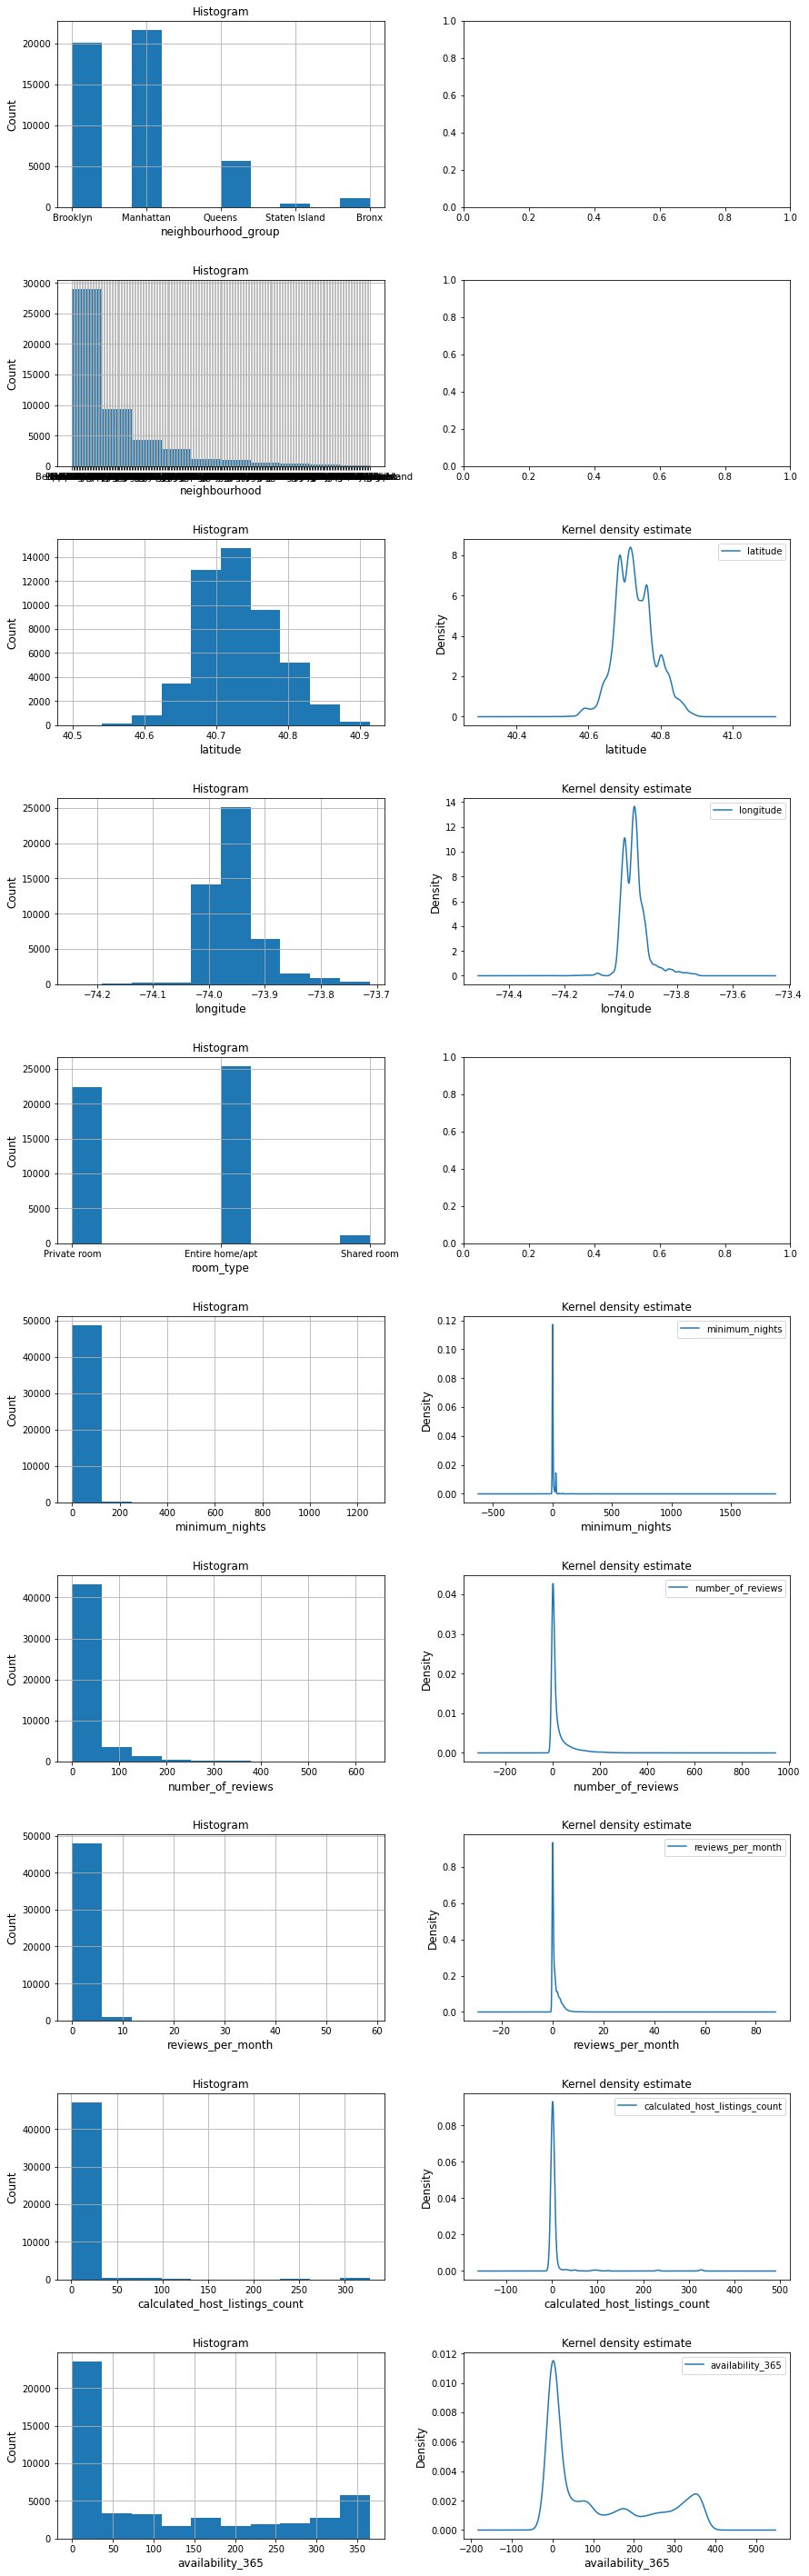

In [13]:
# Список колонок для построения графиков
columns = ['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 
           'calculated_host_listings_count', 'availability_365']
categorical_columns = ['neighbourhood_group', 'neighbourhood', 'room_type']

# Создадим окружение для графиков, для каждой колонки два стобца
fig, axs = plt.subplots(nrows=len(columns), ncols=2, figsize=(13,40))

for index, column in enumerate(columns):
    # В первом столбце отобразим гистограмму
    data[column].hist(ax=axs[index, 0])
    axs[index, 0].set_title('Histogram')
    axs[index, 0].set_xlabel(column, fontsize=12)
    axs[index, 0].set_ylabel('Count', fontsize=12)

    if column in categorical_columns:
        continue
        
    # Во втором столбце отобразим график сглаженной плотности распределения на основе ядерной оценки
    data[column].plot(kind='kde', ax=axs[index, 1])
    axs[index, 1].set_title('Kernel density estimate')
    axs[index, 1].set_xlabel(column, fontsize=12)
    axs[index, 1].set_ylabel('Density', fontsize=12)
    axs[index, 1].legend()

plt.tight_layout(pad=3.0)
plt.show()

Из графиков видно что neighbourhood_group и room_type можно закодировать dummy, а вот neighbourhood сильно большое количество, и что бы не раздувать таблицу очень сильно применим частотное кодирование

In [14]:
data['neighbourhood_group'].value_counts()

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64

In [15]:
data['room_type'].value_counts()

Entire home/apt    25409
Private room       22326
Shared room         1160
Name: room_type, dtype: int64

In [16]:
data['neighbourhood'].value_counts()

Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
                      ... 
Willowbrook              1
New Dorp                 1
Rossville                1
Fort Wadsworth           1
Richmondtown             1
Name: neighbourhood, Length: 221, dtype: int64

In [17]:
neighbourhood_group_encoded = pd.get_dummies(data['neighbourhood_group'], prefix='neighbourhood_group')
data = pd.concat([data, neighbourhood_group_encoded], axis=1)
room_type_encoded = pd.get_dummies(data['room_type'], prefix='room_type')
data = pd.concat([data, room_type_encoded], axis=1)
data['neighbourhood_encoded'] = data['neighbourhood'].map(data['neighbourhood'].value_counts(normalize=True))
data=data.drop(['neighbourhood','room_type','neighbourhood_group'], axis=1)
data.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,neighbourhood_encoded
0,40.64749,-73.97237,149,1,9,0.21,6,365,0,1,0,0,0,0,1,0,0.003579
1,40.75362,-73.98377,225,1,45,0.38,2,355,0,0,1,0,0,1,0,0,0.031598
2,40.80902,-73.94190,150,3,0,0.00,1,365,0,0,1,0,0,0,1,0,0.054361
3,40.68514,-73.95976,89,1,270,4.64,1,194,0,1,0,0,0,1,0,0,0.011699
4,40.79851,-73.94399,80,10,9,0.10,1,0,0,0,1,0,0,1,0,0,0.022845


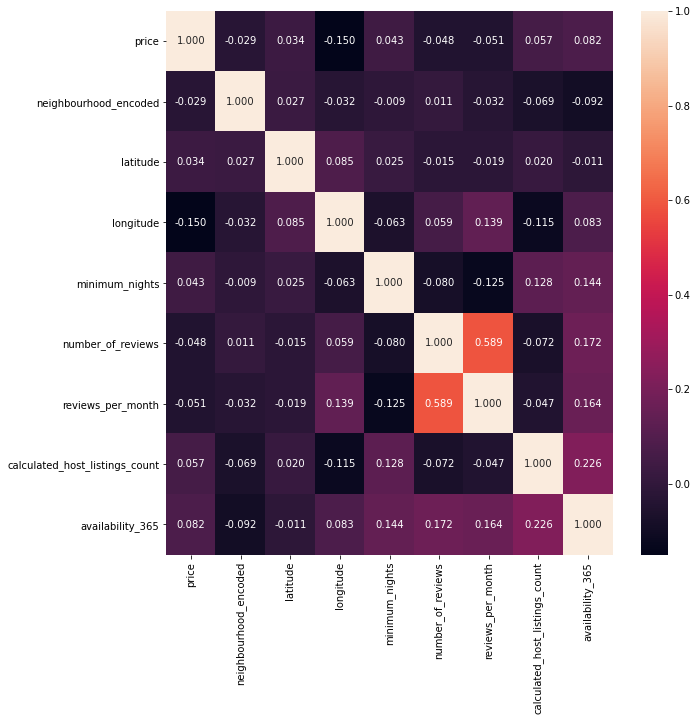

In [18]:

TO_CORR = ['price', 'neighbourhood_encoded', 'latitude', 'longitude', 'minimum_nights', 
           'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
corr = data[TO_CORR].corr()


plt.figure(figsize=(10,10));
sns.heatmap(corr, annot=True, fmt='.3f');

Как видно из графика корреляции, зависимыми друг от друга являются количество всех отзывов и количество отзывов в месяц. Построим графики парных корреляций, действительно ли между признаками наблюдается линейная зависимость.

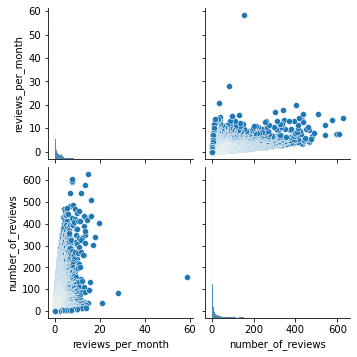

In [19]:
sns.pairplot(data[['reviews_per_month', 'number_of_reviews']], diag_kind="hist");

Линейной зависимости не наблюдается, можно оставлять данные

In [20]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('price', axis=1), data['price'], test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((34226, 16), (14669, 16), (34226,), (14669,))

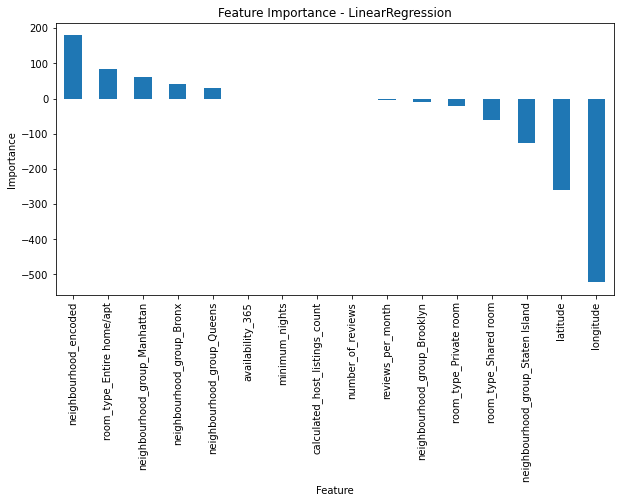

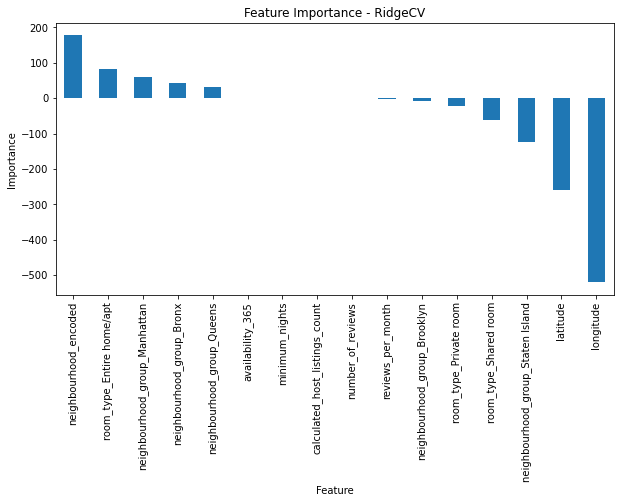

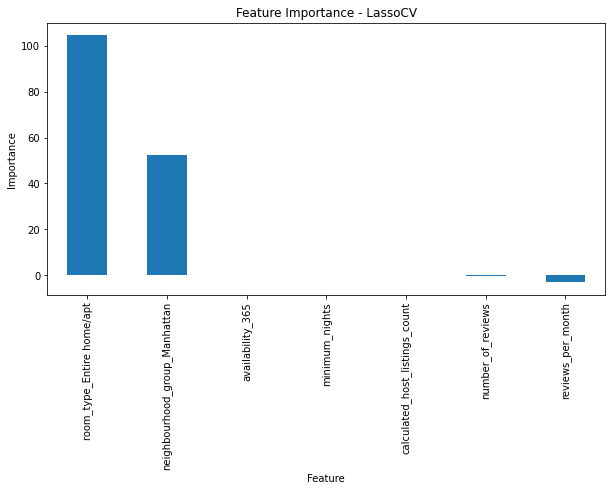

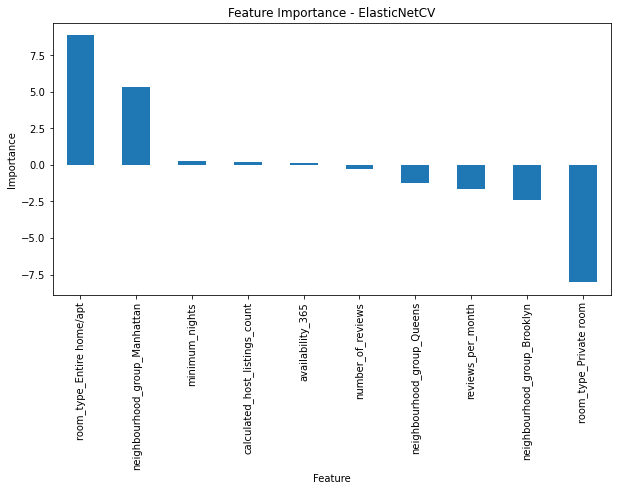

In [21]:
for model_type,model_name in regression_list:
    MAE_value,RMSE_value,R2_value, model = regression_fit(X_train, X_test, y_train, y_test,model_type, model_name)
    feature_importance_plot(X_train,model,model_name)
    result = pd.concat([result, pd.DataFrame([[model_name,MAE_value,RMSE_value,R2_value]], columns=result_columns)])
    

In [22]:
result

,name,MAE,RMSE,R2
0,LinearRegression,71.448396,187.042839,0.133762
0,RidgeCV,71.444968,187.042245,0.133767
0,LassoCV,71.421389,188.070440,0.124218
0,ElasticNetCV,84.185747,196.556788,0.043398


In [23]:
report(result)

Min MAE
LassoCV 71.42138853546328
---------
Min RMSE
RidgeCV 187.04224511283076
---------
MAX R2
RidgeCV 0.1337674275371169


##  Feature Engineering

### Scale

In [24]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

TO_SCALE = ['neighbourhood_encoded', 'latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 
            'reviews_per_month', 'calculated_host_listings_count', 'availability_365']   

for scaler_type,scaler_name in scaler_list:
    for model_type,model_name in regression_list:
        X_train_scaled[TO_SCALE] = scaler_type.fit_transform(X_train[TO_SCALE])
        X_test_scaled[TO_SCALE] = scaler_type.transform(X_test[TO_SCALE])
        MAE_value,RMSE_value,R2_value, model = regression_fit(X_train_scaled, X_test_scaled, y_train, y_test,model_type, model_name)
        result = pd.concat([result, pd.DataFrame([["{} - {}".format(model_name,scaler_name),MAE_value,RMSE_value,R2_value]], columns=result_columns)])



In [25]:
result

,name,MAE,RMSE,R2
0,LinearRegression,71.448396,187.042839,0.133762
0,RidgeCV,71.444968,187.042245,0.133767
0,LassoCV,71.421389,188.070440,0.124218
0,ElasticNetCV,84.185747,196.556788,0.043398
0,LinearRegression - StandardScaler,71.448396,187.042839,0.133762
0,RidgeCV - StandardScaler,71.421794,187.041262,0.133777
0,LassoCV - StandardScaler,71.400891,187.038519,0.133802
0,ElasticNetCV - StandardScaler,71.064859,187.399106,0.130459
0,LinearRegression - RobustScaler,71.448396,187.042839,0.133762
0,RidgeCV - RobustScaler,71.419888,187.041125,0.133778


In [26]:
report(result)

Min MAE
ElasticNetCV - MinMaxScaler 70.25048622068715
---------
Min RMSE
LassoCV - MinMaxScaler 187.02796259125864
---------
MAX R2
LassoCV - MinMaxScaler 0.13389971329997874


#### Попробуем добавить новые переменные

Попробуем заменить координаты на удаленость от центра Манхетана 

<AxesSubplot:>

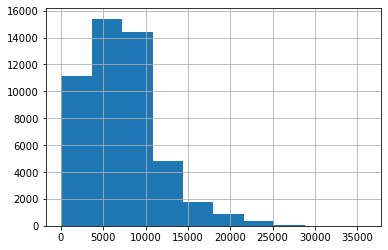

In [27]:
def distance(coord1, coord2):
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    delta_phi       = math.radians(lat2 - lat1)
    delta_lambda    = math.radians(lon2 - lon1)
    
    a = math.sin(delta_phi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(delta_lambda/2)**2
    
    R = 6372800
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

manhattan_coord = (40.758896, -73.985130)
data['distance_to_manhattan'] = data.apply(
    lambda x: distance(coord1 = manhattan_coord, coord2 = (x['latitude'], x['longitude'])), axis=1
)
data.drop(['latitude', 'longitude'], axis=1, inplace=True)

data['distance_to_manhattan'].hist()



In [28]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('price', axis=1), data['price'], test_size=0.3, random_state=42)
TO_SCALE = ['neighbourhood_encoded', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 
            'calculated_host_listings_count', 'availability_365', 'distance_to_manhattan']   
for scaler_type,scaler_name in scaler_list:
    for model_type,model_name in regression_list:
        X_train[TO_SCALE] = scaler_type.fit_transform(X_train[TO_SCALE])
        X_test[TO_SCALE] = scaler_type.transform(X_test[TO_SCALE])
        MAE_value,RMSE_value,R2_value, model = regression_fit(X_train_scaled, X_test_scaled, y_train, y_test,model_type, model_name)
        result = pd.concat([result, pd.DataFrame([["{} - {} + distance_to_manhattan ".format(model_name,scaler_name),MAE_value,RMSE_value,R2_value]], columns=result_columns)])


In [29]:
result

,name,MAE,RMSE,R2
0,LinearRegression,71.448396,187.042839,0.133762
0,RidgeCV,71.444968,187.042245,0.133767
0,LassoCV,71.421389,188.070440,0.124218
0,ElasticNetCV,84.185747,196.556788,0.043398
0,LinearRegression - StandardScaler,71.448396,187.042839,0.133762
0,RidgeCV - StandardScaler,71.421794,187.041262,0.133777
0,LassoCV - StandardScaler,71.400891,187.038519,0.133802
0,ElasticNetCV - StandardScaler,71.064859,187.399106,0.130459
0,LinearRegression - RobustScaler,71.448396,187.042839,0.133762
0,RidgeCV - RobustScaler,71.419888,187.041125,0.133778


In [30]:
report(result)

Min MAE
ElasticNetCV - MinMaxScaler 70.25048622068715
---------
Min RMSE
LassoCV - MinMaxScaler 187.02796259125864
---------
MAX R2
LassoCV - MinMaxScaler 0.13389971329997874


### Обработка выбросов

In [31]:
def outlier_detect_IQR(data, col, lower_border=0.25, upper_border=0.75):
    Q1 =  data['price'].quantile(lower_border)
    Q3 = data['price'].quantile(upper_border)
    IQR = Q3 - Q1
    return data[(data['price'] > (Q1-1.5*IQR)) & (data['price'] < (Q3+1.5*IQR))]

<AxesSubplot:>

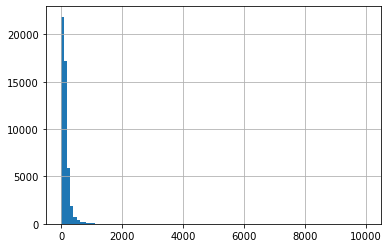

In [32]:
data['price'].hist(bins=100)

<AxesSubplot:>

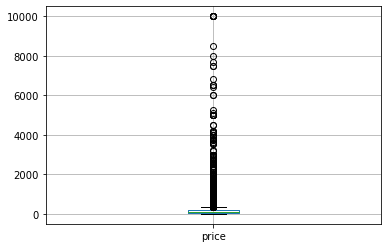

In [33]:
data.boxplot(column=['price'])


In [34]:
data['price'].describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

In [35]:

df_IQR = outlier_detect_IQR(data,'price')
df_IQR['price'].describe()


count    45918.000000
mean       119.947014
std         68.117249
min          0.000000
25%         65.000000
50%        100.000000
75%        159.000000
max        333.000000
Name: price, dtype: float64

In [36]:
df_IQR

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,neighbourhood_encoded,distance_to_manhattan
0,149,1,9,0.21,6,365,0,1,0,0,0,0,1,0,0.003579,12437.905371
1,225,1,45,0.38,2,355,0,0,1,0,0,1,0,0,0.031598,597.912413
2,150,3,0,0.00,1,365,0,0,1,0,0,0,1,0,0.054361,6658.595984
3,89,1,270,4.64,1,194,0,1,0,0,0,1,0,0,0.011699,8477.785710
4,80,10,9,0.10,1,0,0,0,1,0,0,1,0,0,0.022845,5605.370369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,70,2,0,0.00,2,9,0,1,0,0,0,0,1,0,0.075959,9417.952204
48891,40,4,0,0.00,2,36,0,1,0,0,0,0,1,0,0.050414,7710.603930
48892,115,10,0,0.00,1,27,0,0,1,0,0,1,0,0,0.054361,6929.797239
48893,55,1,0,0.00,6,2,0,0,1,0,0,0,0,1,0.040045,527.682827


In [37]:
X_train, X_test, y_train, y_test = train_test_split(df_IQR.drop('price', axis=1), df_IQR['price'], test_size=0.3, random_state=42)
TO_SCALE = ['neighbourhood_encoded', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 
            'calculated_host_listings_count', 'availability_365', 'distance_to_manhattan']   
for scaler_type,scaler_name in scaler_list:
    for model_type,model_name in regression_list:
        X_train[TO_SCALE] = scaler_type.fit_transform(X_train[TO_SCALE])
        X_test[TO_SCALE] = scaler_type.transform(X_test[TO_SCALE])
        MAE_value,RMSE_value,R2_value, model = regression_fit(X_train, X_test, y_train, y_test,model_type, model_name)
        result = pd.concat([result, pd.DataFrame([["{} - {} + distance_to_manhattan + IQR ".format(model_name,scaler_name),MAE_value,RMSE_value,R2_value]], columns=result_columns)])


## ИТОГИ

In [38]:
result

,name,MAE,RMSE,R2
0,LinearRegression,71.448396,187.042839,0.133762
0,RidgeCV,71.444968,187.042245,0.133767
0,LassoCV,71.421389,188.070440,0.124218
0,ElasticNetCV,84.185747,196.556788,0.043398
0,LinearRegression - StandardScaler,71.448396,187.042839,0.133762
...,...,...,...,...
0,ElasticNetCV - MaxAbsScaler + distance_to_manh...,37.383112,50.248056,0.459442
0,LinearRegression - Normalizer + distance_to_ma...,37.090262,50.029268,0.464139
0,RidgeCV - Normalizer + distance_to_manhattan +...,37.090422,50.029104,0.464143
0,LassoCV - Normalizer + distance_to_manhattan +...,37.111165,50.030369,0.464116


In [39]:
report(result)

Min MAE
LinearRegression - StandardScaler + distance_to_manhattan + IQR  36.312185842002194
LinearRegression - RobustScaler + distance_to_manhattan + IQR  36.312185842002194
LinearRegression - MinMaxScaler + distance_to_manhattan + IQR  36.312185842002194
---------
Min RMSE
LinearRegression - RobustScaler + distance_to_manhattan + IQR  49.17620149320745
LinearRegression - MinMaxScaler + distance_to_manhattan + IQR  49.17620149320745
LinearRegression - MaxAbsScaler + distance_to_manhattan + IQR  49.17620149320745
---------
MAX R2
LinearRegression - RobustScaler + distance_to_manhattan + IQR  0.48225770654214417
LinearRegression - MinMaxScaler + distance_to_manhattan + IQR  0.48225770654214417
LinearRegression - MaxAbsScaler + distance_to_manhattan + IQR  0.48225770654214417


Уменьшили МАЕ почти в два раза

Уменьшили RMSE больше чем в три раза

Увеличили R2 почти в четыре раза